# Create CNN Model and Optimize it using Keras Tuner

### first install keras tuner


In [5]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 3.1 MB/s 


In [4]:
# import all required libraries
import tensorflow as tf
from tensorflow import keras  
import numpy as np

In [2]:
print(tf.__version__)

2.7.0


Download the Fashion MNIST DataSet from keras.datasets

In [8]:
fashion_mist = keras.datasets.fashion_mnist

In [9]:
(train_images, train_labels),(test_images, test_labels) = fashion_mist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


### Normalize the data
#### By dividing each pixel to 255.0

In [10]:
train_images= train_images/255.0
test_images = test_images/255.0

In [11]:
train_images[0].shape

  

(28, 28)

#### Change the Shape of data Because we have data with shape(60000,28,28) but Con2D support 4dim of shape (60000,28,28,1) last is the channel here we have grayscale images that's why the last dimenstion is 1 

In [12]:
train_images = train_images.reshape(len(train_images),28,28,1)
test_images = test_images.reshape(len(test_images),28,28,1)

In [13]:
train_images.shape

(60000, 28, 28, 1)

In [6]:
from keras.layers import Dense, Conv2D, Flatten ,Dropout
from keras.models import Model
from keras import Input

In [23]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        # Tune number of filter from between 32 to 128 with step_size of 16 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # Tune size of kernel is 3 or 5
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.Conv2D(
        # Tune number of fliter and kernel size
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        # Tune number of units
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [7]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import matplotlib.pyplot as plt


In [25]:
tuner_search=RandomSearch(build_model,
                          objective='val_accuracy',  # here is max trial is 5 mean our model will train 5 time with different combination of hyperparameters
                          max_trials=5,directory='output',project_name="Mnist Fashion1",overwrite=True)

In [26]:
tuner_search.search(train_images,train_labels,epochs=3,validation_split=0.1)

Trial 5 Complete [00h 00m 51s]
val_accuracy: 0.8970000147819519

Best val_accuracy So Far: 0.8970000147819519
Total elapsed time: 00h 05m 55s
INFO:tensorflow:Oracle triggered exit


In [27]:
model=tuner_search.get_best_models(num_models=1)[0] # this will return list of best models 

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 96)        2496      
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 48)        115248    
                                                                 
 flatten (Flatten)           (None, 19200)             0         
                                                                 
 dense (Dense)               (None, 64)                1228864   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,347,258
Trainable params: 1,347,258
Non-trainable params: 0
_________________________________________________________________


### Now let's train the best model more.

In [29]:
history = model.fit(train_images, train_labels, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.1901 - accuracy: 0.9292 - val_loss: 0.2851 - val_accuracy: 0.9035
Epoch 5/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.1538 - accuracy: 0.9420 - val_loss: 0.2619 - val_accuracy: 0.9083
Epoch 6/10
1688/1688 [==============================] - 19s 12ms/step - loss: 0.1249 - accuracy: 0.9530 - val_loss: 0.2979 - val_accuracy: 0.9073
Epoch 7/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.1041 - accuracy: 0.9611 - val_loss: 0.3123 - val_accuracy: 0.9088
Epoch 8/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0821 - accuracy: 0.9688 - val_loss: 0.3523 - val_accuracy: 0.9092
Epoch 9/10
1688/1688 [==============================] - 17s 10ms/step - loss: 0.0683 - accuracy: 0.9747 - val_loss: 0.4170 - val_accuracy: 0.9067
Epoch 10/10
1688/1688 [==============================] - 22s 13ms/step - loss: 0.0567 - accuracy: 0.9789 - val_loss: 0.4138 

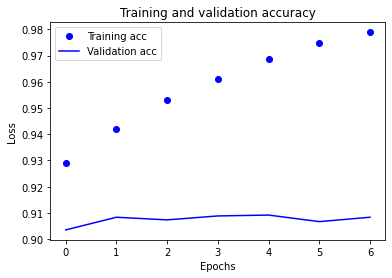

[0.9291666746139526, 0.9419999718666077, 0.9530370235443115, 0.9610925912857056, 0.9688147902488708, 0.9746851921081543, 0.9789259433746338] 
 [0.9035000205039978, 0.9083333611488342, 0.9073333144187927, 0.9088333249092102, 0.909166693687439, 0.9066666960716248, 0.9083333611488342]


In [44]:
epochs = 7
history_dict = history.history
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(range(epochs), acc_values, 'bo', label='Training acc')
plt.plot(range(epochs), val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(acc_values, "\n",val_acc_values)

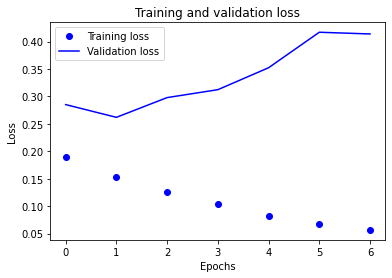

In [46]:
epochs = 7
history_dict = history.history
plt.clf()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plt.plot(range(epochs), loss_values, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### You can see that over model get training accuracy some way around 97 but validation accuracy is 90 its mean our model is overfit 
### let's start main work The work is reduce overfitting 

In [52]:
# save the model 
model.save('./content/outputs/first_model.hdf5')

## Tune Hyperparameter
#### Again tune model with functional Api and tune the hyperparameters.
#### I first try to build model with functional api but keras tuner doesn't support so leave it 

In [84]:
# def tunned_model(hp):  
#   input = Input(28,28,1)
#   x1  = Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=144, step=16),
#         kernel_size=hp.Choice('conv_1_kernel', values = [3,5,7]),
#         activation='relu')(input)
#   x2 = keras.layers.BatchNormalization()(x1)
#   x3 = Conv2D(ilters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
#         kernel_size=hp.Choice('conv_2_kernel', values = [3,5,7]),
#         activation='relu')(x2)
#   x4 = Dropout(0.3)(x3) 
#   x5 = keras.layers.BatchNormalization()(x4)
#   x6 = Conv2D(ilters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
#         kernel_size=hp.Choice('conv_3_kernel', values = [3,5,7]),
#         activation='relu')(x5)
#   x7 = Dropout(0.3)(x6)       
#   x8 = keras.layers.BatchNormalization()(x7)
#   x9 = Flatten()(x1)
#   output = Dense(10, activation='softmax')(x9)
#   model = Model(input, output)

  
#   model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 2e-3,3e-3])),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])
  
  # return model

## let's Build Seqential Model.

In [14]:
def build_model2(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        # Tune number of fliter and kernel size
        filters=hp.Int('conv_1_filter', min_value=32, max_value=144, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5,7]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(
        # Tune number of fliter and kernel size
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5,7]),
        activation='relu'
    ),
    # Tune Dropout Ratio
    keras.layers.Dropout(hp.Choice('dropout_value', values = [0.3,0.5])),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(
        # Tune number of fliter and kernel size
        filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5,7]),
        activation='relu'
    ),
    # Tune Dropout Ratio
    keras.layers.Dropout(hp.Choice('dropout_value', values = [0.3,0.5])),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    # Tune number of units
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), # tune learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [15]:
tuner_search2=RandomSearch(build_model2,
                          objective='val_accuracy',
                          max_trials=5,directory='Tunne output',project_name="Tunne Mnist Fashion",overwrite=True)

In [16]:
tuner_search2.search(train_images,train_labels,epochs=3,validation_split=0.1) 

Trial 5 Complete [00h 01m 23s]
val_accuracy: 0.8629999756813049

Best val_accuracy So Far: 0.9001666903495789
Total elapsed time: 00h 07m 48s
INFO:tensorflow:Oracle triggered exit


In [17]:
tunned_model=tuner_search2.get_best_models(num_models=1)[0]

In [19]:
history = tunned_model.fit(train_images, train_labels, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
1688/1688 [==============================] - 26s 15ms/step - loss: 0.2515 - accuracy: 0.9065 - val_loss: 0.2752 - val_accuracy: 0.8993
Epoch 5/10
1688/1688 [==============================] - 24s 14ms/step - loss: 0.2323 - accuracy: 0.9142 - val_loss: 0.2408 - val_accuracy: 0.9142
Epoch 6/10
1688/1688 [==============================] - 24s 14ms/step - loss: 0.2138 - accuracy: 0.9212 - val_loss: 0.2302 - val_accuracy: 0.9182
Epoch 7/10
1688/1688 [==============================] - 24s 14ms/step - loss: 0.1981 - accuracy: 0.9265 - val_loss: 0.2416 - val_accuracy: 0.9173
Epoch 8/10
1688/1688 [==============================] - 24s 14ms/step - loss: 0.1868 - accuracy: 0.9303 - val_loss: 0.2346 - val_accuracy: 0.9217
Epoch 9/10
1688/1688 [==============================] - 24s 14ms/step - loss: 0.1771 - accuracy: 0.9349 - val_loss: 0.2341 - val_accuracy: 0.9202
Epoch 10/10
1688/1688 [==============================] - 24s 14ms/step - loss: 0.1653 - accuracy: 0.9382 - val_loss: 0.2462 

In [21]:
history2 = tunned_model.fit(train_images, train_labels, epochs=5, validation_split=0.1)

Epoch 1/5
1688/1688 [==============================] - 24s 14ms/step - loss: 0.1562 - accuracy: 0.9421 - val_loss: 0.2455 - val_accuracy: 0.9240
Epoch 2/5
1688/1688 [==============================] - 24s 14ms/step - loss: 0.1504 - accuracy: 0.9437 - val_loss: 0.2334 - val_accuracy: 0.9190
Epoch 3/5
1688/1688 [==============================] - 25s 15ms/step - loss: 0.1465 - accuracy: 0.9459 - val_loss: 0.2349 - val_accuracy: 0.9200
Epoch 4/5
1688/1688 [==============================] - 24s 14ms/step - loss: 0.1380 - accuracy: 0.9478 - val_loss: 0.2218 - val_accuracy: 0.9242
Epoch 5/5
1688/1688 [==============================] - 24s 14ms/step - loss: 0.1312 - accuracy: 0.9523 - val_loss: 0.2332 - val_accuracy: 0.9213


In [30]:
tunned_model.save("model.hdf5")

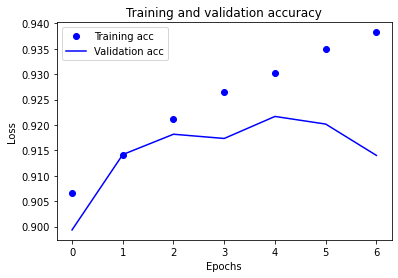

[0.9065185189247131, 0.9141666889190674, 0.9212222099304199, 0.926537036895752, 0.9302777647972107, 0.9348703622817993, 0.9382407665252686] 
 [0.8993333578109741, 0.9141666889190674, 0.9181666374206543, 0.9173333048820496, 0.92166668176651, 0.9201666712760925, 0.9139999747276306]


In [28]:
epochs = 7
history_dict = history.history
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(range(epochs), acc_values, 'bo', label='Training acc')
plt.plot(range(epochs), val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
print(acc_values, "\n",val_acc_values)

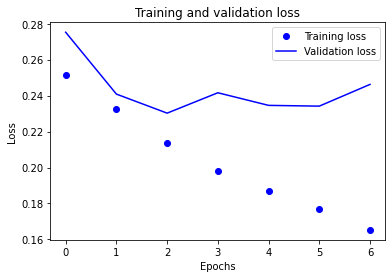

In [29]:
epochs = 7
history_dict = history.history
plt.clf()
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plt.plot(range(epochs), loss_values, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Our Second Model have low overfitting as compare to first Model and have a Accuracy of 92% so Keras_Tuner is a good tool for Hyperparameter Tunning but it doen't support Functional Modeling because i personaly try a lot but it doesn't work.**